In [2]:
from psg import PSG
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import pandas as pd
import constants
from ecg import ECG
from emg import EMG
import eeg
from eeg import EEG
from eog import EOG
from sao2 import *
from matplotlib import pyplot as plt
from scipy import stats
import gc
import sklearn as sk
from sklearn import impute as skImpute
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn import neighbors
from sklearn import mixture
from sklearn import manifold
from sklearn import naive_bayes
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import cluster
from sklearn.cluster import KMeans
#from sklearn_extra.cluster import KMedoids

In [3]:
training_set_1 = ['ins2', 'ins6', 'n11', 'n2']
training_set_2 = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15']
training_set_3 = ['plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6']
training_set_4 = ['rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']

testing_set_1 = ['ins8', 'ins9', 'n5'] 
testing_set_2 = ['nfle16', 'nfle17', 'nfle18', 'nfle19'] 
testing_set_3 = ['plm7', 'plm8', 'plm9']
testing_set_4 = ['rbd18', 'rbd19', 'rbd20']

# Make sure you have the edf and txt files for each individual along with the GitHub modules.

for i in training_set_2:
    psg_data = PSG(i)

    #EEG Feature Extraction
    reload(eeg)
    EEG_columns = eeg.EEG(psg_data.data)
    EEG_columns.extract_features()
    eeg_data = EEG_columns.eeg_features

    #SAO2 Feature Extraction
    oxyData = psg_data.data[['epoch','SAO2']]
    sao2_data = SAO2(oxyData).get_SAO2_metrics()

    #EOG Feature Extraction
    eog_data = EOG(psg_data.data).get_EOG_metrics()

    #EMG Feature Extraction
    sxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "SX1-SX2"]]
    sx = EMG(sxDfInput, signalType = "SX1-SX2")
    sx_data = sx.getMetrics()

    dxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "DX1-DX2"]]
    dx = EMG(dxDfInput, signalType = "DX1-DX2")
    dx_data = dx.getMetrics()

    emgDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "EMG1-EMG2"]]
    emg_columns = EMG(emgDfInput)
    emg_data = emg_columns.getMetrics()

    #ECG Feature Extraction
    ecgDfInput = psg_data.data.loc[:, ["epoch", "ECG1-ECG2"]]
    ecg_columns = ECG(ecgDfInput)
    ecg_data = ecg_columns.getMetrics()

    plethDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "PLETH"]]
    pleth = ECG(plethDfInput, signalType = 'PLETH')
    pleth_data = pleth.getMetrics()

    #Combine and Export Data
    stage_1 = pd.merge(psg_data.txtData, eeg_data, how = 'left', on='epoch')
    stage_2 = pd.merge(stage_1, sao2_data, how = 'left', on='epoch')
    stage_3 = pd.merge(stage_2, eog_data, how = 'left', on='epoch')
    stage_4 = pd.merge(stage_3, sx_data, how = 'left', on='epoch')
    stage_5 = pd.merge(stage_4, dx_data, how = 'left', on='epoch')
    stage_6 = pd.merge(stage_5, emg_data, how = 'left', on='epoch')
    stage_7 = pd.merge(stage_6, ecg_data, how = 'left', on='epoch')
    final = pd.merge(stage_7, pleth_data, how = 'left', on='epoch')

    final.to_csv(i+'.csv')
    print(i+" successfully exported!")


FileNotFoundError: [Errno 2] No such file or directory: 'nfle10.txt'

In [130]:
training = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15', 'plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6', 'rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17', 'ins2', 'ins6', 'n11', 'n2']
testing = ['ins8', 'ins9', 'n3', 'n5', 'nfle16', 'nfle17', 'nfle18', 'nfle19', 'plm7', 'plm8', 'plm9', 'rbd18', 'rbd19', 'rbd20']
allData = training + testing
#allData = ['n2', 'n3', 'n5', 'n11', 'ins8', 'ins9', 'ins2', 'ins6']
#allData = ['rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']
#allData = ["n11", "n2", "ins2", "ins6"]
firstNumericCol = 6 # Includes age
filepath = 'final_data/'
final = pd.DataFrame()
oversample = False  # Set to True to turn on SMOTE before
undersample = "rand_ncr"   
    # renn - Repeated Edited Nearest Neighbors
    # ncr - Neighborhood clearing rule
    # rand - Random Undersampling
    #   Randomly deletes datapoints from majority classes to match number from minority classes
    #   ** Reduces sample size by a lot, good for Isomap and more involved dimensionality reduction
    # rand_ncr - Random then NCR

for dataset in allData: # Stuff in the loop is done on each dataset individually before combining
    thisData = pd.read_csv(filepath + dataset + '.csv') # Create an untracked local data folder
    column_names = thisData.columns[firstNumericCol - 1:]

    # Add a patient column based on the file name so can be used to do groupby operations
    thisData.insert(1, "Patient", dataset)

    # Truncate based on shortest column before NaN's:
    lastNonNaNEachCol = thisData.notna()[::-1].idxmax()
    thisData = thisData.truncate(after = min(lastNonNaNEachCol))
    
    # Fill in missing data using KNN
    impute_KNN = thisData.iloc[:, firstNumericCol:]
    imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
    thisData.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)

    # Combine with full dataset
    if final.empty:
        final = thisData
    else:
        final = pd.concat([final, thisData])
    
# Drop current "_norm" cols:
for col in final.columns:
    if "_norm" in col:
        final.drop(col, axis=1, inplace=True)

# Normalize (Subtract average within same patient):
for patient in final["Patient"].unique():
    thisPatientMeans = final[final["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    final[final["Patient"] == patient].iloc[:, firstNumericCol:] -= thisPatientMeans
    
#Box-Cox
for column in final.columns[firstNumericCol:]:
    try:
        final[column] = final[column].abs()
        box_cox_trans = stats.boxcox(final[column])[0]
        final[column] = box_cox_trans
    except:
        continue
    #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
    #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
print("Box-Cox completed.")  

#Robust Scaling
subset1 = final.iloc[:,:firstNumericCol]
subset2 = final.iloc[:,firstNumericCol:]

scaler = preprocessing.RobustScaler() # By default, centers and scales
robust_df = scaler.fit_transform(subset2)
final.iloc[:, firstNumericCol:] = robust_df
#robust_df = pd.DataFrame(robust_df, columns = column_names)
print("Robust Scaling completed.")

# Outlier Removal (Local Outlier Factor)
#keep_outliers = ['EMG']
n_neighbors = 20
LOF = neighbors.LocalOutlierFactor(n_neighbors = 20)
LOF.fit_predict(final.iloc[:, firstNumericCol:])
lof_factors = LOF.negative_outlier_factor_
final['lof'] = lof_factors
quartiles = final['lof'].abs().quantile([0.25, 0.75])
#print(quartiles)
interQuartileRange = quartiles[0.75] - quartiles[0.25]
#outlierCutoff = -1 * (quartiles[0.75] + 1.5 * interQuartileRange)
outlierCutoff = -1000
outliers = final[final['lof'] <= outlierCutoff]
final = final[final['lof'] > outlierCutoff]
display(outliers)
#print(outlierCutoff)
#pd.DataFrame(lof_factors).to_csv('lof.csv')


#Encoding (Sleep Stage)
final.drop("Unnamed: 0", axis=1, inplace=True)

final.insert(2, "sleep_stage", np.zeros(len(final)))

for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

final.drop("Sleep Stage", axis=1, inplace=True)

# Encoding (Condition)
conditionColumns = pd.DataFrame()
for patient in pd.unique(final['Patient']):
    thisPatientSeries = (final[final['Patient'] == patient])["condition"]
    thisPatientDf = thisPatientSeries.to_frame("condition")
    for condition in constants.CONDITION_TO_BINARY:
        if condition == thisPatientDf.at[0, 'condition']:
            binary = constants.CONDITION_TO_BINARY.get(condition)

            if binary[0] == 0:
                thisPatientDf.insert(1, "condition_0", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(1, "condition_0", np.ones(len(thisPatientDf)))

            if binary[1] == 0:
                thisPatientDf.insert(2, "condition_1", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(2, "condition_1", np.ones(len(thisPatientDf)))

            if binary[2] == 0:
                thisPatientDf.insert(3, "condition_2", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(3, "condition_2", np.ones(len(thisPatientDf)))

            if binary[3] == 0:
                thisPatientDf.insert(4, "condition_3", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(4, "condition_3", np.ones(len(thisPatientDf)))
    
    if conditionColumns.empty:
        conditionColumns = thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]
    else: # ConditionColumns already initialized
        conditionColumns = pd.concat([conditionColumns, thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]])
final.insert(5, "rbd", conditionColumns["condition_0"])
final.insert(6, "ins", conditionColumns["condition_1"])
final.insert(7, "nfle", conditionColumns["condition_2"])
final.insert(8, "plm", conditionColumns["condition_3"])

final.drop("condition", axis=1, inplace=True)

print('Encoding completed.')


if oversample or undersample:
    # SMOTE to correct imbalanced dataset (do on a per-patient basis):
    balanced_final = pd.DataFrame()
    indexOfGenderCol = final.columns.to_list().index('gender')
    indexOfPatientCol = final.columns.to_list().index('Patient')
    for patient in final["Patient"].unique():
        thisPatientData = final[final['Patient'] == patient]
        thisPatientGender = thisPatientData['gender'].iloc[0]
            # Save this because will add it back in after SMOTE. SMOTE only works with numerical.
        thisPatientData.drop("Patient", axis = 1, inplace = True)
        thisPatientData.drop("gender", axis = 1, inplace = True)

        allNumericCols = final.columns.to_list()
        allNumericCols.remove('Patient')
        allNumericCols.remove('gender')

        if oversample:
            smote = SMOTE(sampling_strategy = 'not majority')

            try:
                balancedDatapoints, balancedLabels = smote.fit_resample(
                    thisPatientData[allNumericCols].to_numpy(),
                    thisPatientData['sleep_stage']
                )
            except ValueError: # This occurs when there are less points in a sleep stage than specified k-neighbors
                smote = SMOTE(sampling_strategy = 'not majority', k_neighbors = 3)
                balancedDatapoints, balancedLabels = smote.fit_resample(
                    thisPatientData[allNumericCols].to_numpy(),
                    thisPatientData['sleep_stage'],
                )
        elif undersample == 'ncr':
            ncr = NeighbourhoodCleaningRule()
            balancedDatapoints, balancedLabels = ncr.fit_resample(
                thisPatientData[allNumericCols].to_numpy(),
                thisPatientData['sleep_stage']
            )
        elif undersample == 'renn':
            renn = NeighbourhoodCleaningRule(
                sampling_strategy = [0, 2] # The stages to undersample. 0 is wake, and 2 is NREM2
            )
            balancedDatapoints, balancedLabels = renn.fit_resample(
                thisPatientData[allNumericCols].to_numpy(),
                thisPatientData['sleep_stage']
            )
        elif undersample == 'rand':
            #dictOfCountOfEachStage = {}
            #for stage in final["sleep_stage"].unique():
            #    dictOfCountOfEachStage[str(stage)] = final['sleep_stage'].value_counts()[stage]

            # Set number of wake and N2 samples to match REM
            #dictOfCountOfEachStage["0.0"] = dictOfCountOfEachStage["5.0"]
            #dictOfCountOfEachStage["2.0"] = dictOfCountOfEachStage["5.0"]

            rand = RandomUnderSampler(
                #sampling_strategy = dictOfCountOfEachStage # The stages to undersample.
            )
            balancedDatapoints, balancedLabels = rand.fit_resample(
                thisPatientData[allNumericCols].to_numpy(),
                thisPatientData['sleep_stage'].astype(str)
            )
        elif undersample == 'rand_ncr':
            rand = RandomUnderSampler(
                #sampling_strategy = dictOfCountOfEachStage # The stages to undersample.
            )
            balancedDatapoints, balancedLabels = rand.fit_resample(
                thisPatientData[allNumericCols].to_numpy(),
                thisPatientData['sleep_stage'].astype(str)
            )

            ncr = NeighbourhoodCleaningRule()
            balancedDatapoints, balancedLabels = ncr.fit_resample(
                balancedDatapoints,
                balancedLabels.astype(float)
            )


        balanced_numeric = pd.DataFrame(balancedDatapoints, columns = allNumericCols)
        balanced_numeric.insert(indexOfPatientCol, 'Patient', patient)
        balanced_numeric.insert(indexOfGenderCol, 'gender', thisPatientGender)

        if balanced_final.empty:
            balanced_final = balanced_numeric
        else:
            balanced_final = pd.concat([balanced_final, balanced_numeric])

    final = balanced_final
print("Datapoint count:", len(final.index))



#Robust Scaling
#subset1 = final.iloc[:,:firstNumericCol]
#subset2 = final.iloc[:,firstNumericCol:]

#scaler = preprocessing.RobustScaler() # By default, centers and scales
#robust_df = scaler.fit_transform(subset2)
#robust_df = pd.DataFrame(robust_df, columns = column_names)
#print("Robust Scaling done for " + dataset)

#Export
#final = pd.concat([subset1, robust_df], axis = 1)
final.reset_index(inplace=True)
final = final.iloc[:,1:]
final.to_csv('final.csv')
print('Dataset successfully exported!')

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Box-Cox completed.
Robust Scaling completed.


,Unnamed: 0,Patient,epoch,Sleep Stage,condition,gender,age,beta_relative_power,alpha_relative_power,theta_relative_power,...,hf_ECG1-ECG2,lf/hf_ECG1-ECG2,breathingrate_ECG1-ECG2,bpm_PLETH,rmssd_PLETH,lf_PLETH,hf_PLETH,lf/hf_PLETH,breathingrate_PLETH,lof
374,374,nfle10,374,R,Nocturnal Frontal Lobe Epilepsy,M,-1.226634,0.861127,-0.106323,-0.200780,...,1.206724e+44,-0.217233,-0.333333,0.230308,-0.769933,-8.044957e-02,-4.261779e-01,0.580927,-0.333333,-4.726525e+12
387,387,nfle10,387,R,Nocturnal Frontal Lobe Epilepsy,M,-1.226634,0.361742,0.026538,-0.056699,...,1.456903e+00,-0.238898,-0.333333,0.142725,-0.891205,8.043760e+41,7.393874e+41,0.156227,-0.666667,-1.342836e+10
218,218,nfle11,218,S4,Nocturnal Frontal Lobe Epilepsy,M,-0.871179,0.164300,-0.289261,-0.037130,...,1.887464e+27,-0.168941,-0.333333,0.458659,-0.316816,-1.937387e-01,-1.486257e-01,-0.097662,1.333333,-7.149315e+04
278,278,nfle11,278,S2,Nocturnal Frontal Lobe Epilepsy,M,-0.871179,1.281765,0.227393,-0.161137,...,1.674266e+30,-0.233286,0.666667,0.634031,-0.185051,6.586959e-01,-3.520297e-02,0.764468,-2.333333,-1.327825e+07
958,958,nfle12,958,R,Nocturnal Frontal Lobe Epilepsy,F,0.320179,0.843859,0.991950,0.438805,...,1.031628e+21,969.021791,-0.311804,-1.155606,-1.097688,-1.158495e-02,3.008907e+00,-0.780868,-2.333333,-2.023685e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,442,plm8,442,S4,Periodic Leg Movement,M,0.070029,-0.396885,0.200032,0.516301,...,-2.104246e-01,2.324852,-1.000000,-0.991805,-0.994744,5.028860e+40,7.057266e+41,-0.947462,0.333333,-2.057481e+10
75,75,plm9,75,S4,Periodic Leg Movement,M,0.000000,-1.712608,-1.412905,-1.120133,...,-2.061491e-01,0.994332,0.000000,0.846784,-0.014397,1.453099e+40,8.508873e+39,0.829153,-0.666667,-1.707416e+09
169,169,plm9,169,R,Periodic Leg Movement,M,0.000000,0.229838,0.442971,0.651271,...,-1.874295e-01,0.920940,0.000000,0.338020,0.701326,1.107782e+49,9.262338e+49,-0.894980,1.000000,-1.400141e+48
515,515,plm9,515,W,Periodic Leg Movement,M,0.000000,-0.296301,0.591565,-1.129284,...,2.011044e+31,-0.199289,-0.333333,-0.209206,0.368361,2.173242e+00,7.229392e-01,0.932752,-0.666667,-7.743383e+07


Encoding completed.


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Datapoint count: 4734
Dataset successfully exported!


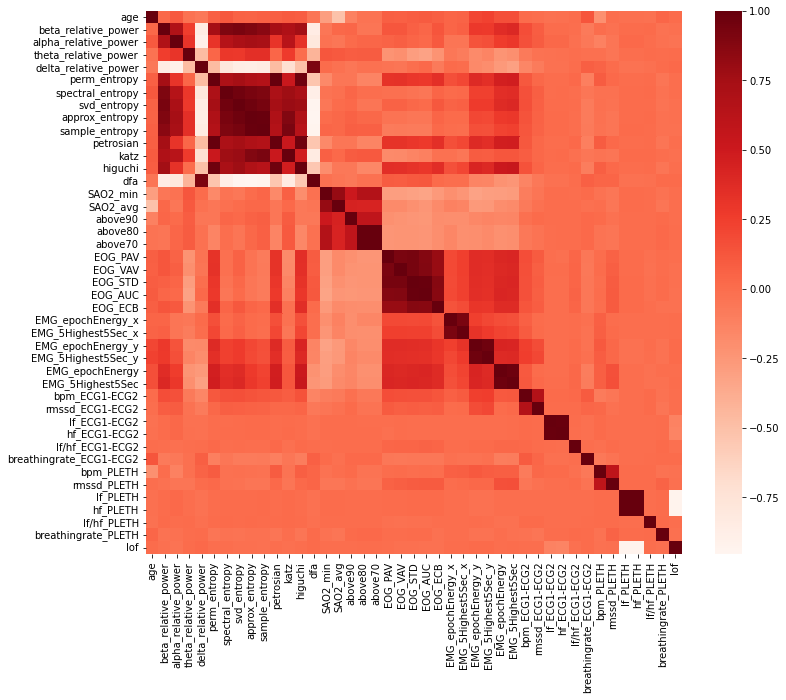

                Feature A             Feature B      Corr
779              hf_PLETH              lf_PLETH  1.000000
170               above70               above80  0.999971
50              petrosian          perm_entropy  0.999754
44         sample_entropy        approx_entropy  0.989938
252               EOG_AUC               EOG_STD  0.985059
560          hf_ECG1-ECG2          lf_ECG1-ECG2  0.984895
434      EMG_5Highest5Sec       EMG_epochEnergy  0.973893
35         approx_entropy           svd_entropy  0.967932
76                higuchi             petrosian  0.966469
377    EMG_5Highest5Sec_y     EMG_epochEnergy_y  0.964431
71                higuchi          perm_entropy  0.962713
27            svd_entropy      spectral_entropy  0.956683
86                    dfa        approx_entropy  0.954178
85                    dfa           svd_entropy  0.939353
230               EOG_STD               EOG_VAV  0.937158
87                    dfa        sample_entropy  0.936931
43         sam

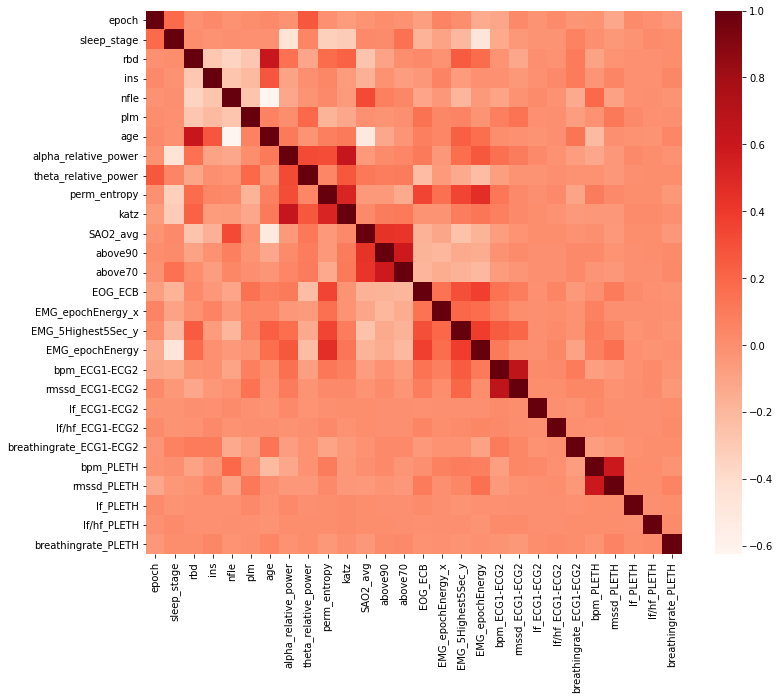

In [131]:
# Feature Removal Based on Between-Feature Correlation:

## INPUTS ##:
threshold = 0.8 # Abs correlation above which feature is removed

# 1. Calculate Correlation Matrix of the Predictors
columnsToCorr = list(final.columns)
safeFeatures = ['Patient', 'epoch', 'sleep_stage', 'rbd', 'ins', 'nfle', 'plm'] # Features that we won't remove
for i in safeFeatures:
    columnsToCorr.remove(i)

plt.figure(figsize=(12,10))
cor = final[columnsToCorr].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

# 2. Determine the two predictors associated with the largest absolute pairwise correlation
# Remove (set = 0) half of the matrix because symmetric:
lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask
corLowerTriangle = cor.where(lowerTriangleMask)
corAbs = corLowerTriangle.abs() # Consider absolute correlation

# Build sorted dataframe of form: ["Feature A", "Feature B", corr]
pairwiseCorr = corAbs.stack().reset_index()
pairwiseCorr.columns = ['Feature A','Feature B','Corr']

# Isolate correlations to remove
pairwiseCorr = pairwiseCorr[pairwiseCorr['Corr'] > threshold]
pairwiseCorr.sort_values('Corr', ascending = False, inplace = True)
print(pairwiseCorr)

# 3. Determine the average correlation between A and B and every other feature:
# Create an average correlation dataframe of form [feature, averageCorr]
averageCorr = pd.DataFrame(cor.abs().mean(axis = 1), cor.index, ['avgCorr'])

# Loop through pairwiseCorr, make a list of features to remove. 
featuresToRemove = []
for index, row in pairwiseCorr.iterrows():
    featureA = row['Feature A']
    featureB = row['Feature B']
    featureA_avgCorr = averageCorr.loc[featureA, 'avgCorr']
    featureB_avgCorr = averageCorr.loc[featureB, 'avgCorr']

    # If A has larger average correlation, remove it. Otherwise, remove B
    if featureA_avgCorr >= featureB_avgCorr:
        if featureA not in featuresToRemove:
            featuresToRemove.append(featureA)
    else:
        if featureB not in featuresToRemove:
            featuresToRemove.append(featureB)

# Report results:
print("Threshold: " + str(threshold))
print(featuresToRemove)

# Dataset with features removed
correlationFeatureRemoval = final.drop(featuresToRemove, axis = 1)
print("Remaining Features: " + str(correlationFeatureRemoval.shape[1]))

# Show the correlation matrix after feature removal
plt.figure(figsize=(12,10))
cor2 = correlationFeatureRemoval.corr()
sns.heatmap(cor2, annot=False, cmap=plt.cm.Reds)
plt.show()
    

In [120]:
print(averageCorr)
print(averageCorr.loc["above70", "avgCorr"])

                          avgCorr
age                      0.103027
beta_relative_power      0.297451
alpha_relative_power     0.220246
theta_relative_power     0.158931
delta_relative_power     0.271018
perm_entropy             0.307076
spectral_entropy         0.293042
svd_entropy              0.310177
approx_entropy           0.302268
sample_entropy           0.298630
petrosian                0.307599
katz                     0.268214
higuchi                  0.314748
dfa                      0.293993
SAO2_min                 0.175063
SAO2_avg                 0.139732
above90                  0.127696
above80                  0.148788
above70                  0.148626
EOG_PAV                  0.219717
EOG_VAV                  0.221423
EOG_STD                  0.223387
EOG_AUC                  0.222872
EOG_ECB                  0.195139
EMG_epochEnergy_x        0.142617
EMG_5Highest5Sec_x       0.152633
EMG_epochEnergy_y        0.234667
EMG_5Highest5Sec_y       0.223030
EMG_epochEnerg

In [132]:
# Feature Selection with Mutual Information

info_selection = pd.concat([correlationFeatureRemoval['sleep_stage'], correlationFeatureRemoval.iloc[:, 9:]], axis=1)

safe_features = list(correlationFeatureRemoval.iloc[:, :9].columns)

info_scores = []

for x in info_selection.columns[1:]:
    score = metrics.normalized_mutual_info_score(info_selection['sleep_stage'], info_selection[x])
    column_and_score = (x, score)
    info_scores.append(column_and_score)
    
target_columnscore = pd.DataFrame(info_scores).sort_values(by=1, ascending = False)

top_5_cols = safe_features+list(target_columnscore[0][:5])
top_10_cols = safe_features+list(target_columnscore[0][:10])
top_20_cols = safe_features+list(target_columnscore[0][:20])
top_30_cols = safe_features+list(target_columnscore[0][:30])

top_5_data = correlationFeatureRemoval[top_5_cols]
top_10_data = correlationFeatureRemoval[top_10_cols]
top_20_data = correlationFeatureRemoval[top_20_cols]
top_30_data = correlationFeatureRemoval[top_30_cols]

print(target_columnscore)

                          0         1
17              rmssd_PLETH  0.347595
1      theta_relative_power  0.347505
0      alpha_relative_power  0.347505
7                   EOG_ECB  0.347505
9        EMG_5Highest5Sec_y  0.347505
8         EMG_epochEnergy_x  0.347505
10          EMG_epochEnergy  0.347505
3                      katz  0.347505
2              perm_entropy  0.347505
16                bpm_PLETH  0.347261
12          rmssd_ECG1-ECG2  0.346634
11            bpm_ECG1-ECG2  0.345863
19              lf/hf_PLETH  0.343615
18                 lf_PLETH  0.343203
14          lf/hf_ECG1-ECG2  0.334371
13             lf_ECG1-ECG2  0.324004
15  breathingrate_ECG1-ECG2  0.197069
4                  SAO2_avg  0.180765
20      breathingrate_PLETH  0.089503
6                   above70  0.035219
5                   above90  0.033198


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discr

In [93]:
# Separate Training and Testing:

def splitTestTrain(dataToSplit, reference = pd.DataFrame()):
    trainingLabels = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15', 'plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6', 'rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17', 'ins2', 'ins6', 'n11', 'n2']
    testingLabels = ['ins8', 'ins9', 'n3', 'n5', 'nfle16', 'nfle17', 'nfle18', 'nfle19', 'plm7', 'plm8', 'plm9', 'rbd18', 'rbd19', 'rbd20']
    if reference.empty:
        trainingData = dataToSplit[dataToSplit['Patient'].isin(trainingLabels)]
        testingData = dataToSplit[dataToSplit['Patient'].isin(testingLabels)]
    else:
        trainingData = dataToSplit[reference['Patient'].isin(trainingLabels)]
        testingData = dataToSplit[reference['Patient'].isin(testingLabels)]     
    return trainingData, testingData


In [162]:
# Function for running PCA or TSNE or Isomap
def dimReduction(dataToReduce, type = "PCA", n_components = 2, perplexity = 30, n_iters = 1000, simplifiedTarget = False, n_neighbors = 12):
    data = dataToReduce.iloc[:,8:].to_numpy()
    target = dataToReduce.loc[:, "sleep_stage"].to_numpy()
    if type == "PCA":
        model = PCA(n_components = n_components)
        data_reduced = model.fit_transform(data)
    elif type == "TSNE":
        model = TSNE(n_components = n_components, perplexity = perplexity, n_iter = n_iters)
        data_reduced = model.fit_transform(data)
    elif type == "Isomap":
        # Isomap:
        model = manifold.Isomap(n_neighbors = n_neighbors, n_components = n_components)
        model.fit(data)
        data_reduced = model.transform(data)
    elif type == "LLE":
        model = manifold.LocallyLinearEmbedding(n_neighbors = n_neighbors, n_components = n_components)
        model.fit(data)
        data_reduced = model.transform(data)
    elif type == "MLLE":
        model = manifold.LocallyLinearEmbedding(method = 'modified', n_neighbors = n_neighbors, n_components = n_components)
        model.fit(data)
        data_reduced = model.transform(data)
    elif type == "SE":
        model = manifold.SpectralEmbedding(n_components = n_components)
        model.fit(data)
        data_reduced = model.fit_transform(data)
    elif type == "SE_rbf":
        model = manifold.SpectralEmbedding(n_components = n_components, affinity = 'rbf')
        model.fit(data)
        data_reduced = model.fit_transform(data)

    if simplifiedTarget:
        simplifiedTarget = []
        for i in target:
            if i >= 1.0 and i <= 4.0:
                simplifiedTarget.append(1.0)
            elif i == 5.0:
                simplifiedTarget.append(2.0)
            else:
                simplifiedTarget.append(0.0)
        target = np.array(simplifiedTarget)

    return data_reduced, target

In [56]:
# Function for Plotting PSA, TSNE, or Clusters:
def plot_dimReduction(dataToPlot, label, label_meaning = "target", scaleFactors = [1, 1, 1], eliv = None, azim = None):
    cols = np.shape(dataToPlot)[1]
    if cols == 1:
        # 1D Plot
        #sf = 10**49
        sf = scaleFactors[0]
        df_reduced = pd.DataFrame(dataToPlot / sf, columns=["pca_feature_1"])
        df_reduced[label_meaning] = label

        # Creating dataset
        np.random.seed(10)
        
        data_0 = df_reduced.loc[df_reduced[label_meaning] == 0, "pca_feature_1"]
        data_1 = df_reduced.loc[df_reduced[label_meaning] == 1, "pca_feature_1"]
        data_2 = df_reduced.loc[df_reduced[label_meaning] == 2, "pca_feature_1"]
        data_3 = df_reduced.loc[df_reduced[label_meaning] == 3, "pca_feature_1"]
        data_4 = df_reduced.loc[df_reduced[label_meaning] == 4, "pca_feature_1"]
        data_5 = df_reduced.loc[df_reduced[label_meaning] == 5, "pca_feature_1"]
        data = [data_0, data_1, data_2, data_3, data_4, data_5]
        
        fig = plt.figure(figsize=(10,5))
        
        # Configure axes
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
        plt.xlabel("sleep_stage")
        plt.ylabel("feature_1")
        
        # Creating plot (handles outliers)
        bp = ax.boxplot(data, showfliers=False)  

        # show plot
        plt.show()

    elif cols == 2:
        # Dataframe
        df_reduced = pd.DataFrame(dataToPlot, columns=["feature_1", "feature_2"])
        df_reduced[label_meaning] = label

        # Outlier Removal
        original_rows = len(df_reduced)
        df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
        print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

        # Optional Code to Correctly Scale/Reduce
        #df_reduced = df_reduced[df_reduced["feature_1"] < 0]

        # 2D Plot
        fig = plt.figure(figsize=(10,10))
        sns.scatterplot(data=df_reduced, x="feature_1", y="feature_2", hue=label_meaning, palette="deep")

        fig.show()

    elif cols == 3:
        # Dataframe
        df_reduced = pd.DataFrame(dataToPlot, columns=["feature_1", "feature_2", "feature_3"])
        df_reduced[label_meaning] = label
        # Outlier Removal
        original_rows = len(df_reduced)
        df_reduced = df_reduced[(np.abs(stats.zscore(df_reduced)) < 3.5).all(axis=1)]
        print("Number of Outliers Removed: " + str(original_rows - len(df_reduced)))

        # Optional Scaling Factor
        #sf_x = 10**45
        sf_x = scaleFactors[0]
        sf_y = scaleFactors[1]
        sf_z = scaleFactors[2]

        # 3D Plot
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection = '3d')
        #cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
        cmap = ListedColormap(sns.color_palette("tab10", 256).as_hex())
        sc = ax.scatter(xs=df_reduced["feature_1"] / sf_x, ys=df_reduced["feature_2"] / sf_y, zs=df_reduced["feature_3"] / sf_z, c=df_reduced[label_meaning], cmap=cmap)
        if eliv and azim:
            ax.view_init(eliv, azim)

        # Axes
        ax.set_xlabel('feature_1')
        ax.set_ylabel('feature_2')
        ax.set_zlabel('feature_3')

        # Legend
        plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

        # Optional Scaling
        # plt.xlim([-1.2554, -1.2548])

        plt.show()
        
        

In [10]:
# Define a function to assign the majority sleep stage to each cluster - this is necessary to use supervised metrics 
# comparing against target values:

def stage_for_cluster(cluster_ids, target, simplifiedTarget = False):
    cluster_stage_assignment={}

    if simplifiedTarget:
        simplifiedTarget = []
        for i in target:
            if i >= 1.0 and i <= 4.0:
                simplifiedTarget.append(1.0)
            elif i == 5.0:
                simplifiedTarget.append(2.0)
            else:
                simplifiedTarget.append(0.0)
        target = np.array(simplifiedTarget)
    
    for i in set(cluster_ids):
        stage_list = pd.Series(target[cluster_ids == i])
        stage_ct = stage_list.groupby(by = stage_list).count().sort_values(ascending = False)
        stage_ct = stage_ct.reset_index()
        true_stage = stage_ct['index'][0]
        cluster_stage_assignment[i] = true_stage
        
    predicted = np.array(pd.Series(cluster_ids).map(cluster_stage_assignment))
    return predicted



In [11]:
# Get Clustering Metrics Using Cluster IDs Returned from a Clustering

def get_clustering_metrics(cluster_ids, target, simplifiedTarget = False):
    if simplifiedTarget:
        simplifiedTarget = []
        for i in target:
            if i >= 1.0 and i <= 4.0:
                simplifiedTarget.append(1.0)
            elif i == 5.0:
                simplifiedTarget.append(2.0)
            else:
                simplifiedTarget.append(0.0)
        target = np.array(simplifiedTarget)

    cms={}
    predicted_labels = stage_for_cluster(cluster_ids, target)
    cms['NMI'] = metrics.normalized_mutual_info_score(target, predicted_labels)
    cms['F1'] = metrics.f1_score(target, predicted_labels, average = 'weighted')
    cms['Homogeneity'] = metrics.homogeneity_score(target, predicted_labels)
    cms['Rand Stat (Acc) (Best is 1)'] = metrics.rand_score(target, predicted_labels)
    cms['Fowlkes-Mallows (Best is 1)'] = metrics.fowlkes_mallows_score(target, predicted_labels)
    
    metric_dict = pd.concat([pd.Series(cms.keys()), pd.Series(cms.values())], axis=1)
    metric_dict.columns = ['Metric', 'Score']
    return metric_dict
    

In [65]:
# Call these on dimensionality reduction output to do over/undersampling after PCA, TSNE, etc.

def postUndersampling(dataToUndersample, label, method = "ncr"):
    if method == 'ncr':
        ncr = NeighbourhoodCleaningRule()
        balancedDatapoints, balancedLabels = ncr.fit_resample(
            dataToUndersample,
            label
        )

    return balancedDatapoints, balancedLabels


def postOversampling(dataToOversample, label):
    smote = SMOTE(sampling_strategy = 'not majority')

    balancedDatapoints, balancedLabels = smote.fit_resample(
        dataToOversample,
        label
    )

    return balancedDatapoints, balancedLabels

In [34]:
trainingTop10, testingTop10 = splitTestTrain(top_10_data)

Number of Outliers Removed: 20


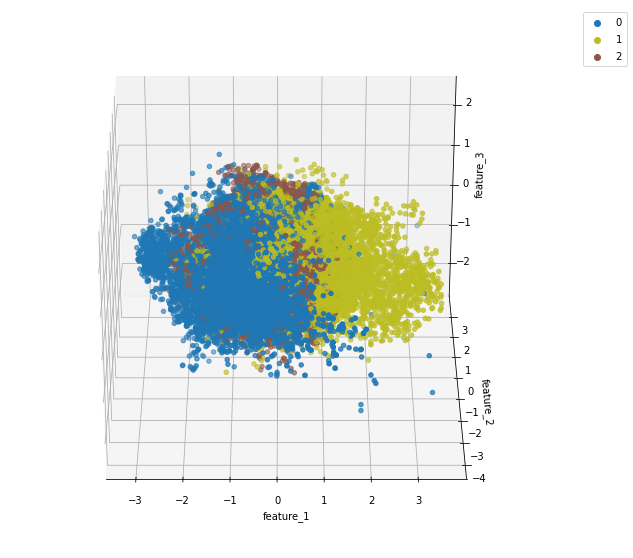

Number of Outliers Removed: 20


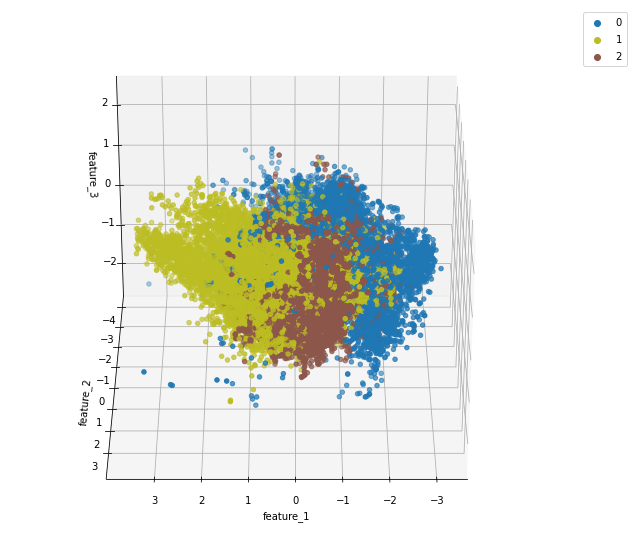

Number of Outliers Removed: 27


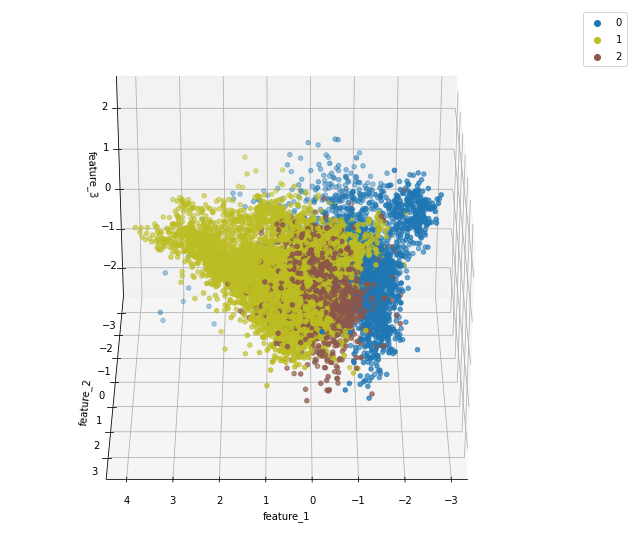

Number of Outliers Removed: 27


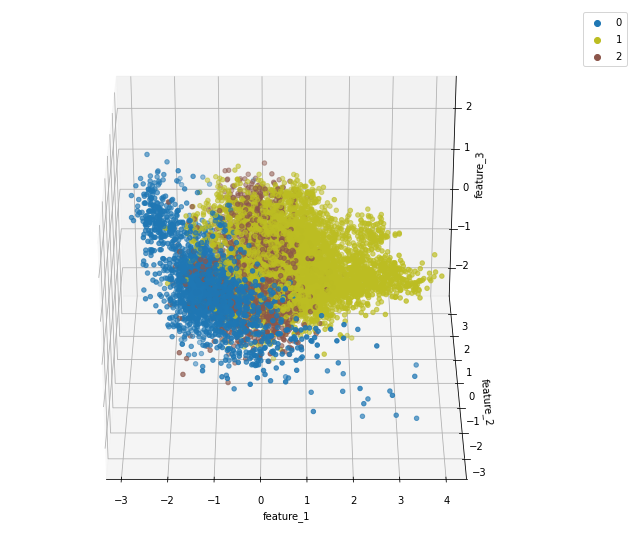

In [117]:
# Run PCA on Top 10
n_components = 5
testing_pca, target = dimReduction(
    top_10_data,
    type = "PCA",
    n_components = n_components,
    simplifiedTarget=True
    )
plot_dimReduction(testing_pca, target, label_meaning = "Target", scaleFactors = [1, 1, 1])

trainingPCATop10, testingPCATop10 = splitTestTrain(testing_pca, top_10_data)
trainingPCATop10_label, testingPCATop10_label = splitTestTrain(target, top_10_data)

trainingPCATop10, trainingPCATop10_label = postUndersampling(trainingPCATop10, trainingPCATop10_label)
testingPCATop10, testingPCATop10_label = postUndersampling(testingPCATop10, testingPCATop10_label)
trainingPCATop10, trainingPCATop10_label = postOversampling(trainingPCATop10, trainingPCATop10_label)
#testingPCATop10, testingPCATop10_label = postOversampling(testingPCATop10, testingPCATop10_label)

plot_dimReduction(
    trainingPCATop10[:, [2,3,4]],
    trainingPCATop10_label, 
    label_meaning = "Target", 
    scaleFactors = [1, 1, 1], 
    eliv = 30, 
    azim = -90
)
plot_dimReduction(
    trainingPCATop10[:, [2,3,4]],
    trainingPCATop10_label, 
    label_meaning = "Target", 
    scaleFactors = [1, 1, 1], 
    eliv = 30, 
    azim = 90
)
plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    testingPCATop10_label,
    label_meaning = "Target",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = 90
)
plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    testingPCATop10_label,
    label_meaning = "Target",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = -90
)

Number of Outliers Removed: 27


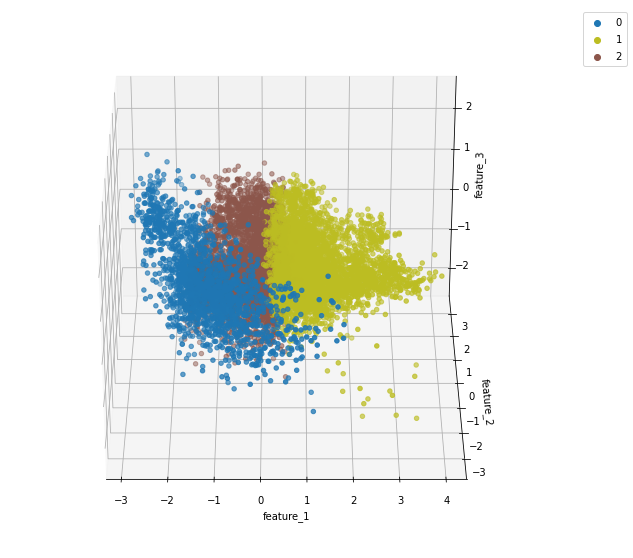

Number of Outliers Removed: 27


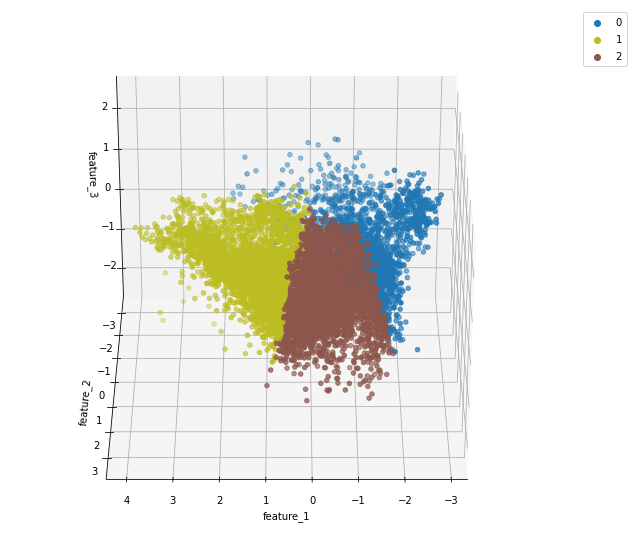

Number of Outliers Removed: 27


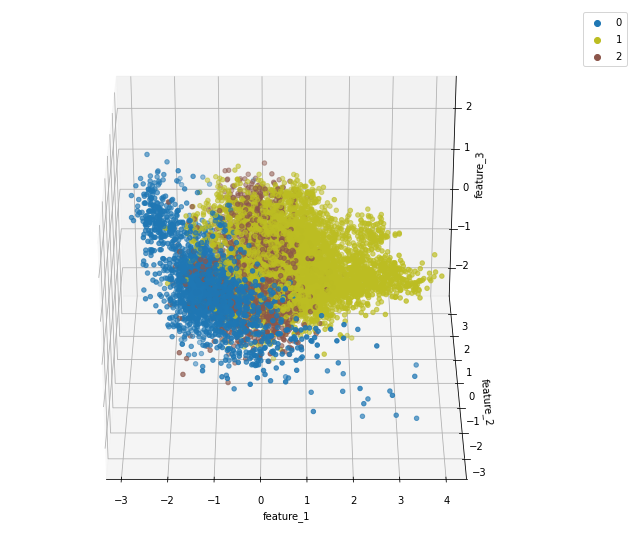

Number of Outliers Removed: 27


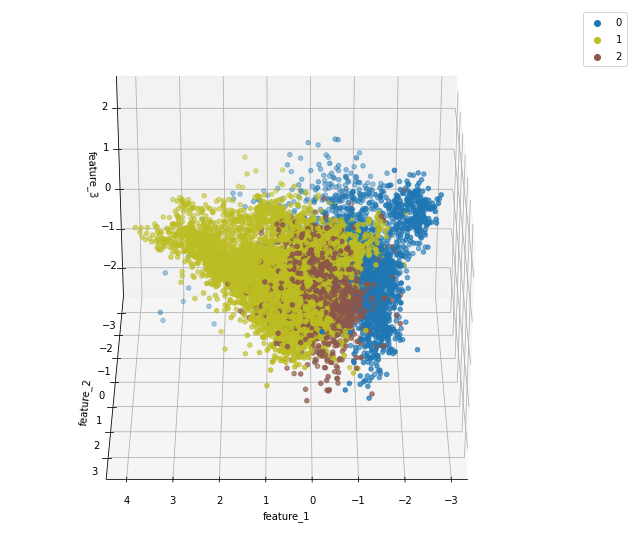

                        Metric     Score
0                          NMI  0.457960
1                           F1  0.908952
2                  Homogeneity  0.440386
3  Rand Stat (Acc) (Best is 1)  0.838390
4  Fowlkes-Mallows (Best is 1)  0.880811
Mean Accuracy: 0.6845791949817042


In [118]:
naiveBayes = naive_bayes.GaussianNB()
naiveBayes.fit(trainingPCATop10[:, [2,3,4]], trainingPCATop10_label)
predictions = naiveBayes.predict(testingPCATop10[:, [2,3,4]])

plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    predictions,
    label_meaning = "Prediction",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = -90
)
plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    predictions,
    label_meaning = "Prediction",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = 90
)
plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    testingPCATop10_label,
    label_meaning = "Target",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = -90
)
plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    testingPCATop10_label,
    label_meaning = "Target",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = 90
)

print(get_clustering_metrics(predictions, testingPCATop10_label, simplifiedTarget = True))
print("Mean Accuracy:", naiveBayes.score(testingPCATop10[:, [2,3,4]], testingPCATop10_label))


Number of Outliers Removed: 27


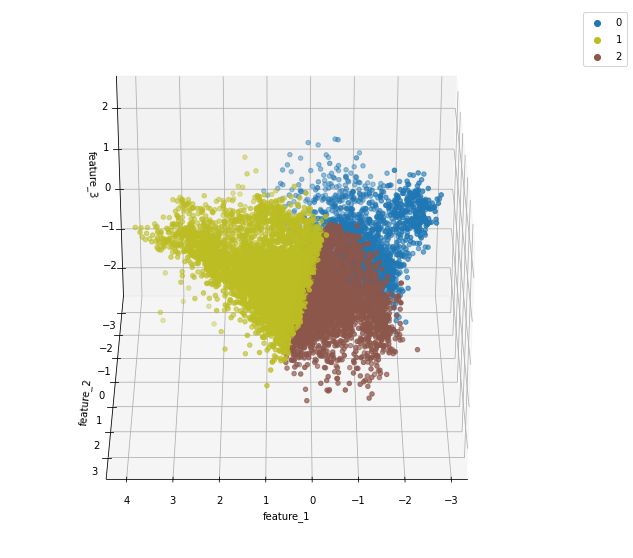

Number of Outliers Removed: 27


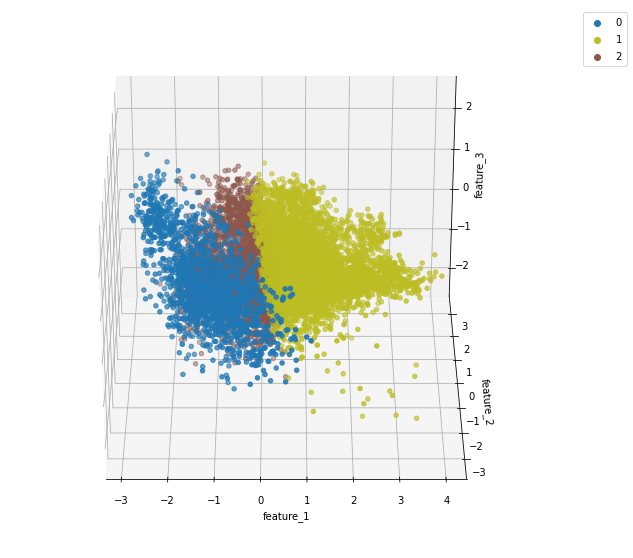

Number of Outliers Removed: 27


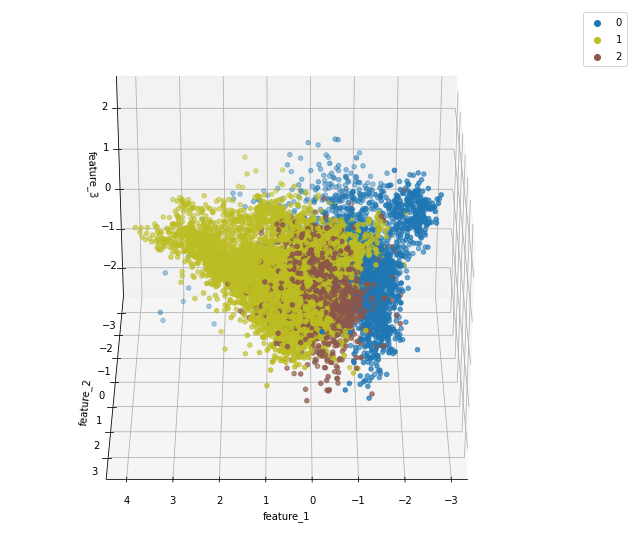

Number of Outliers Removed: 27


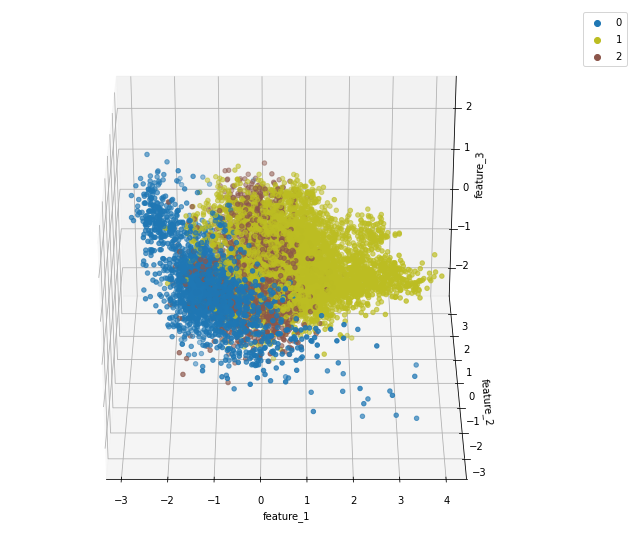

                        Metric     Score
0                          NMI  0.305100
1                           F1  0.665150
2                  Homogeneity  0.228416
3  Rand Stat (Acc) (Best is 1)  0.656167
4  Fowlkes-Mallows (Best is 1)  0.720126
Mean Accuracy: 0.709147935180345


In [119]:
logReg = linear_model.LogisticRegression(
    multi_class='auto'
)
logReg.fit(trainingPCATop10[:, [2,3,4]], trainingPCATop10_label)
predictions_logReg = logReg.predict(testingPCATop10[:, [2,3,4]])

plot_dimReduction(testingPCATop10[:, [2,3,4]],
    predictions_logReg,
    label_meaning = "Prediction",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = 90
)
plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    predictions_logReg,
    label_meaning = "Prediction",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = -90
)
plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    testingPCATop10_label,
    label_meaning = "Target",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = 90
)
plot_dimReduction(
    testingPCATop10[:, [2,3,4]],
    testingPCATop10_label,
    label_meaning = "Target",
    scaleFactors = [1, 1, 1],
    eliv = 30,
    azim = -90
)

print(get_clustering_metrics(predictions_logReg, testingPCATop10_label, simplifiedTarget = False))
print("Mean Accuracy:", logReg.score(testingPCATop10[:, [2,3,4]], testingPCATop10_label))

Number of Outliers Removed: 0


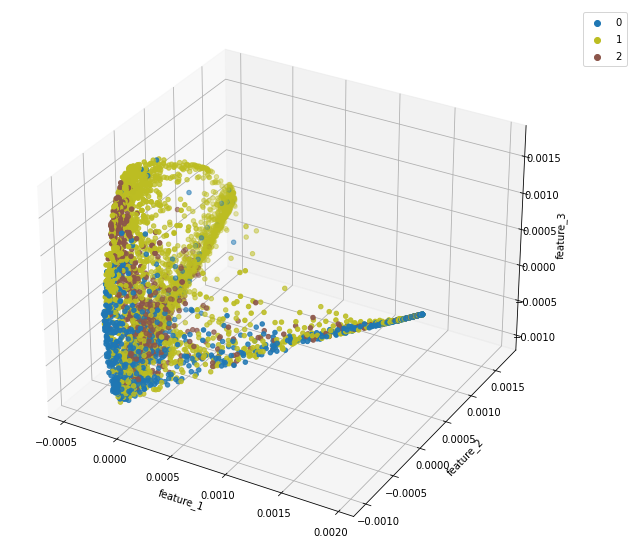

Number of Outliers Removed: 0


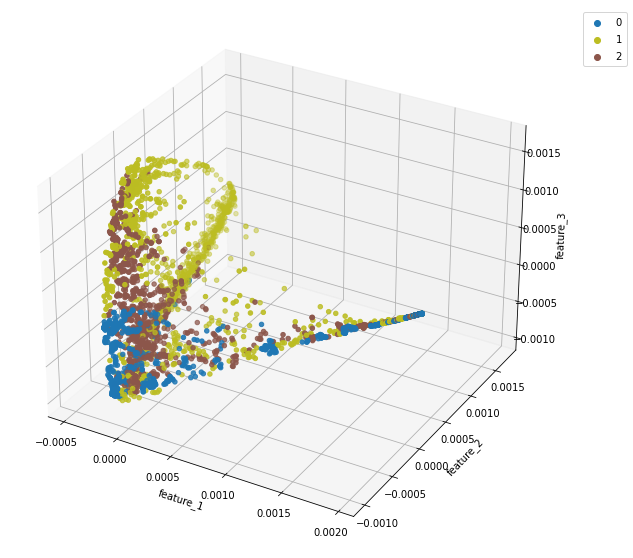

Number of Outliers Removed: 0


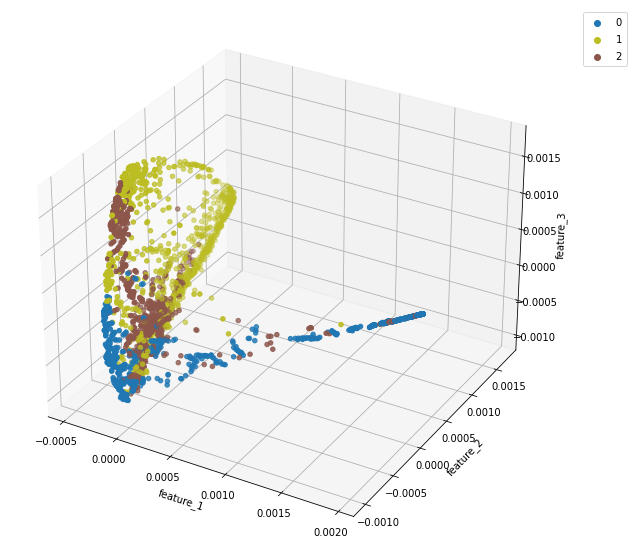

In [176]:
# Run Isomap on Top 10
n_components = 3
top10_isomap, target = dimReduction(
    top_10_data,
    type = "SE",
    n_components = n_components,
    simplifiedTarget=True,
    n_neighbors = 4
    )
plot_dimReduction(top10_isomap, target, label_meaning = "Target", scaleFactors = [1, 1, 1])

trainingIsoTop10, testingIsoTop10 = splitTestTrain(top10_isomap, top_10_data)
trainingIsoTop10_label, testingIsoTop10_label = splitTestTrain(target, top_10_data)

trainingIsoTop10, trainingIsoTop10_label = postUndersampling(trainingIsoTop10, trainingIsoTop10_label)
testingIsoTop10, testingIsoTop10_label = postUndersampling(testingIsoTop10, testingIsoTop10_label)
trainingIsoTop10, trainingIsoTop10_label = postOversampling(trainingIsoTop10, trainingIsoTop10_label)
testingIsoTop10, testingIsoTop10_label = postOversampling(testingIsoTop10, testingIsoTop10_label)

plot_dimReduction(trainingIsoTop10, trainingIsoTop10_label, label_meaning = "Target", scaleFactors = [1, 1, 1])
plot_dimReduction(testingIsoTop10, testingIsoTop10_label, label_meaning = "Target", scaleFactors = [1, 1, 1])

Number of Outliers Removed: 0


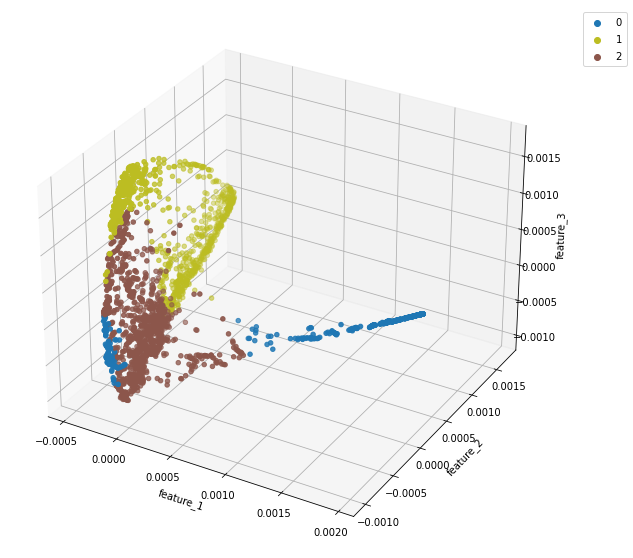

Number of Outliers Removed: 0


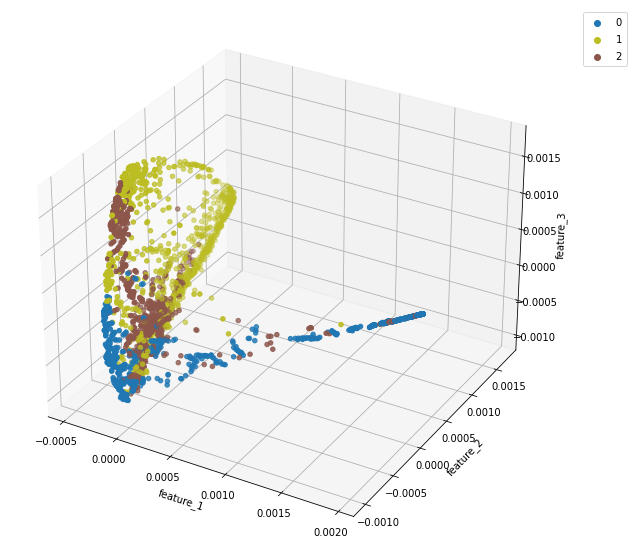

                        Metric     Score
0                          NMI  0.351395
1                           F1  0.672851
2                  Homogeneity  0.343407
3  Rand Stat (Acc) (Best is 1)  0.673093
4  Fowlkes-Mallows (Best is 1)  0.532477
Mean Accuracy: 0.6655543196143864


In [177]:
#trainingIsoTop10, trainingIsoTop10_label = postUndersampling(trainingPCATop10, trainingPCATop10_label)
#testingIsoTop10, testingIsoTop10_label = postUndersampling(testingPCATop10, testingPCATop10_label)

naiveBayes = naive_bayes.GaussianNB()
naiveBayes.fit(trainingIsoTop10, trainingIsoTop10_label)
predictions = naiveBayes.predict(testingIsoTop10)

plot_dimReduction(testingIsoTop10, predictions, label_meaning = "Prediction", scaleFactors = [1, 1, 1])
plot_dimReduction(testingIsoTop10, testingIsoTop10_label, label_meaning = "Target", scaleFactors = [1, 1, 1])

print(get_clustering_metrics(predictions, testingIsoTop10_label, simplifiedTarget = False))
print("Mean Accuracy:", naiveBayes.score(testingIsoTop10, testingIsoTop10_label))

In [171]:
logReg = linear_model.LogisticRegression(
    multi_class='auto'
)
logReg.fit(trainingIsoTop10, trainingIsoTop10_label)
predictions_logReg = logReg.predict(testingIsoTop10)

plot_dimReduction(testingIsoTop10, predictions_logReg, label_meaning = "Prediction", scaleFactors = [1, 1, 1])
plot_dimReduction(testingIsoTop10, testingIsoTop10_label, label_meaning = "Target", scaleFactors = [1, 1, 1])

print(get_clustering_metrics(predictions_logReg, testingIsoTop10_label, simplifiedTarget = False))
print("Mean Accuracy:", naiveBayes.score(testingIsoTop10, testingIsoTop10_label))

                        Metric     Score
0                          NMI  0.000000
1                           F1  0.086993
2                  Homogeneity  0.000000
3  Rand Stat (Acc) (Best is 1)  0.177231
4  Fowlkes-Mallows (Best is 1)  0.420988
Mean Accuracy: 0.43285939968404424


In [42]:
trainingIsomapTop10, testingIsomapTop10 = splitTestTrain(testing_pca, top_10_data)
trainingIsomapTop10_label, testingIsomapTop10_label = splitTestTrain(target, top_10_data)
plot_dimReduction(trainingIsomapTop10, trainingIsomapTop10_label, label_meaning = "Target", scaleFactors = [1, 1, 1])
plot_dimReduction(testingIsomapTop10, testingIsomapTop10_label, label_meaning = "Target", scaleFactors = [1, 1, 1])

#pd.DataFrame(trainingIsomapTop10).to_csv("IsomapOutput/trainingIsomapTop10_ncr.csv")
#pd.DataFrame(trainingIsomapTop10_label).to_csv("IsomapOutput/trainingIsomapTop10_label_ncr.csv")
#pd.DataFrame(testingIsomapTop10).to_csv("IsomapOutput/testingIsomapTop10_ncr.csv")
#pd.DataFrame(testingIsomapTop10_label).to_csv("IsomapOutput/testingIsomapTop10_label_ncr.csv")

Number of Outliers Removed: 146


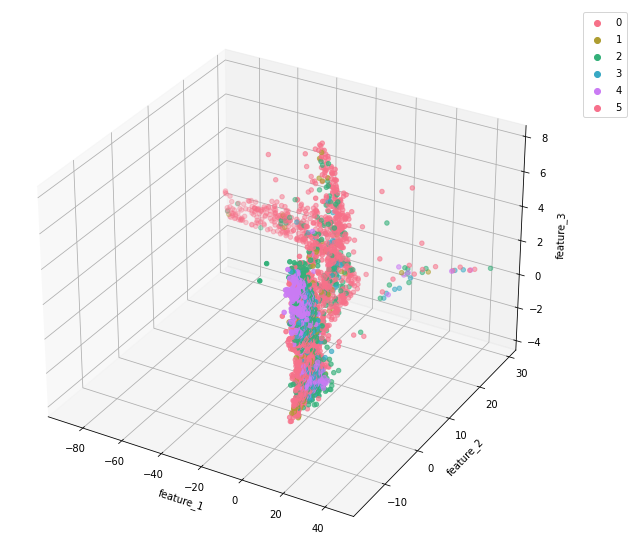

Number of Outliers Removed: 596


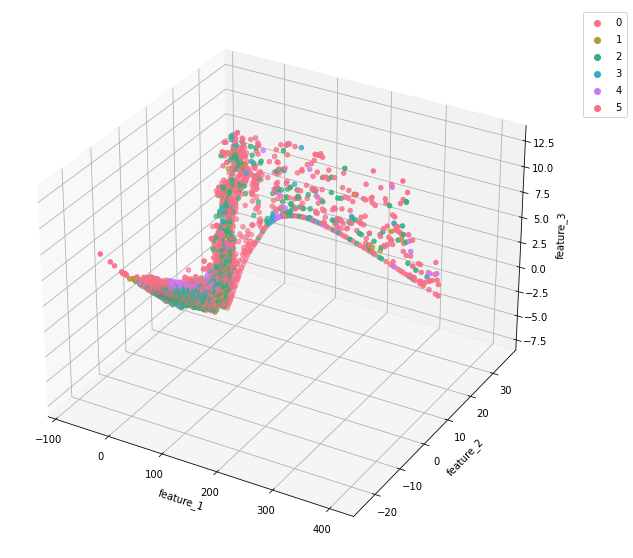

In [35]:
# Run PCA on Top 10
n_components = 5
testing_pca, target = dimReduction(
    testingTop10,
    type = "Isomap",
    n_components = n_components,
    simplifiedTarget=False
    )
plot_dimReduction(testing_pca, target, label_meaning = "Target", scaleFactors = [1, 1, 1])

training_pca, target = dimReduction(
    trainingTop10,
    type = "Isomap",
    n_components = n_components,
    simplifiedTarget=False
    )
plot_dimReduction(training_pca, target, label_meaning = "Target", scaleFactors = [1, 1, 1])

Number of Outliers Removed: 13


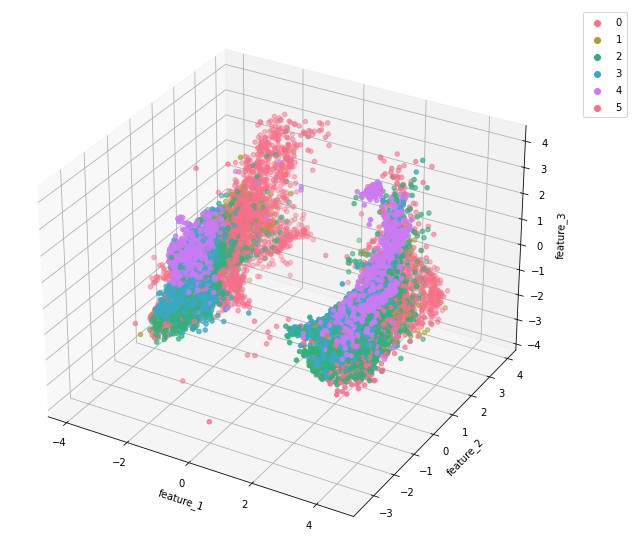

Number of Outliers Removed: 6


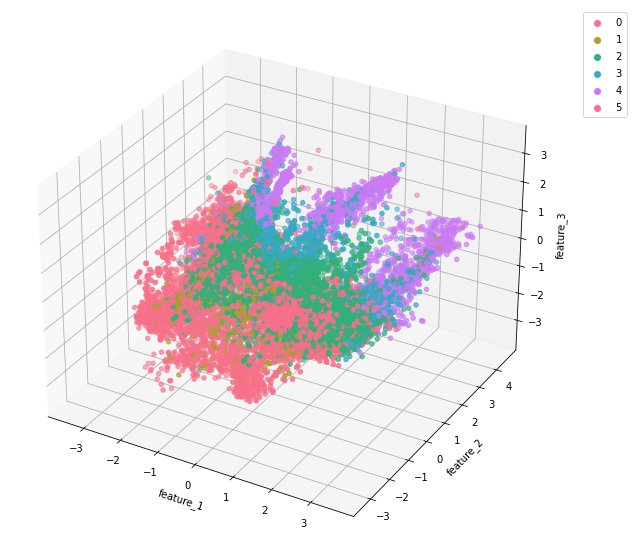

In [33]:
# Run PCA on Top 5
n_components = 3
testing_pca, target = dimReduction(
    testingTop10,
    type = "Isomap",
    n_components = n_components,
    simplifiedTarget=False
    )
plot_dimReduction(testing_pca, target, label_meaning = "Target", scaleFactors = [1, 1, 1])

training_pca, target = dimReduction(
    trainingTop10,
    type = "Isomap",
    n_components = n_components,
    simplifiedTarget=False
    )
plot_dimReduction(training_pca, target, label_meaning = "Target", scaleFactors = [1, 1, 1])

Number of Outliers Removed: 0


<ipython-input-31-ac8dce549690>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


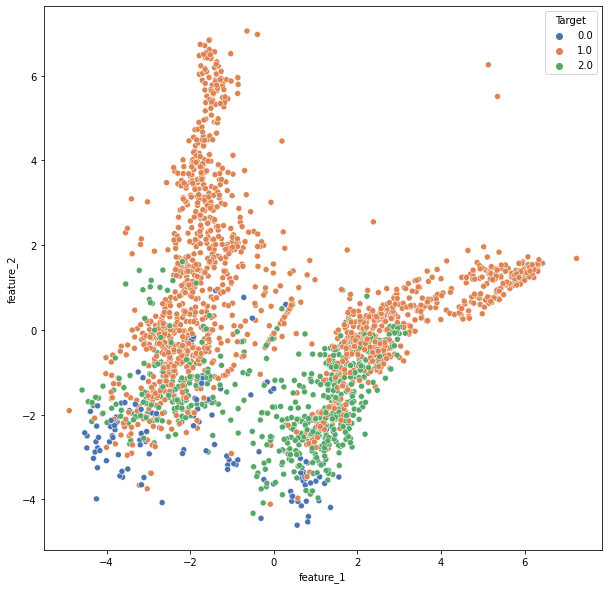

In [39]:
# Run Isomap
n_components = 3
data_reduced, target = dimReduction(top_10_data, type = "Isomap", n_components = n_components, simplifiedTarget=True)
plot_dimReduction(data_reduced[:, [1,2]], target, label_meaning = "Target", scaleFactors = [1, 1, 1])